
![upgit_20240514_1715625551.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240514_1715625551.png)

![upgit_20240514_1715627040.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240514_1715627040.png)

![upgit_20240514_1715629668.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240514_1715629668.png)

![upgit_20240515_1715781804.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240515_1715781804.png)

## 提取所有像素進行CNN

In [3]:
import cv2
import numpy as np
import os
import zipfile
# from google.colab.patches import cv2_imshow
import tensorflow as tf
import pandas as pd
import seaborn as sns # 绘制分类变量的计数直方图
import matplotlib.pyplot as plt
tf.__version__

'2.16.1'

## 圖片轉像素資料

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os
import cv2
import zipfile
import numpy as np

# 解壓縮資料集
path = './Datasets/homer_bart_1.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

# 準備圖片路徑
directory = './homer_bart_1'
files = [os.path.join(directory, f) for f in sorted(os.listdir(directory))]

# 設置圖片固定像素
height, width = 128, 128  
images = []  
classes = []  

# 遍歷圖片文件
for image_path in files:  
    try:
        # 讀取圖片
        image = cv2.imread(image_path)  
        H, W = image.shape[:2]  
    except:
        continue  # 如果無法讀取圖像，跳過該圖像

    # 調整圖片大小為指定的寬度和高度
    image = cv2.resize(image, (width, height))  
    # 將圖片轉換為灰度圖片
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
    # 將圖片平坦化為一維數組
    image = image.ravel()  
    
    # 將圖片添加到 images 數組中
    images.append(image)  
    
    # 根據文件名判斷類別，如果文件名以 'b' 開頭，類別為 0，否則為 1
    image_name = os.path.basename(os.path.normpath(image_path))
    class_name = 0 if image_name.startswith('b') else 1
    # 將圖片類別添加到 classes 數組中
    classes.append(class_name)  

# 將資料由陣列轉換為 numpy 格式
X = np.asarray(images)
y = np.asarray(classes)

# 打印資料類型和形狀
print(type(X), type(y))
print(X.shape, y.shape)  # 16384 = 128 * 128

# 函数返回一个包含两个元素的元组，第一个元素是 y 中唯一值的列表，第二个元素是每个唯一值对应的出现次数。
print(np.unique(y, return_counts=True))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(269, 16384) (269,)
(array([0, 1]), array([160, 109]))


(array([0, 1]), array([160, 109]))


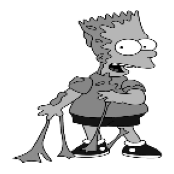

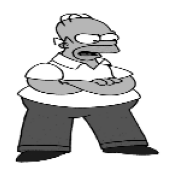

In [12]:
# 查看原資料
image_np = cv2.cvtColor(X[0].reshape(width, height), cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image_np)

image_np = cv2.cvtColor(X[200].reshape(width, height), cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image_np)


<Axes: xlabel='y', ylabel='count'>

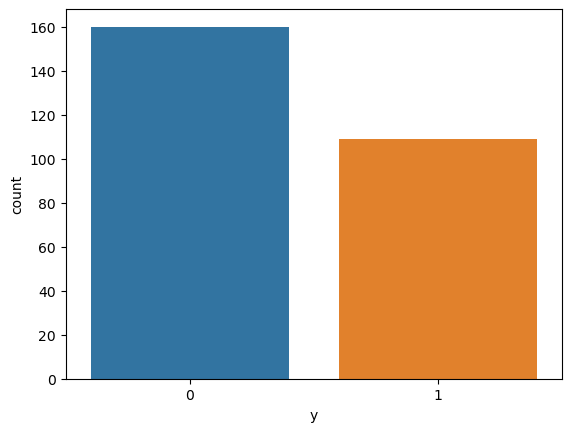

In [10]:
# 将NumPy数组转换为Pandas DataFrame，并将列标记为分类变量
df = pd.DataFrame({'y': y})
df['y'] = df['y'].astype('category')

# 绘制计数直方图
sns.countplot(data=df, x='y')

## 數據標準化

使用了 scikit-learn 庫中的 MinMaxScaler 類，對數據進行了最小-最大規範化（也稱為歸一化）處理。

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
print(X[0].max(), X[0].min()) # (1.0000000000000002, 0.0)

1.0 0.0


## 訓練集與資料集

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((215, 16384), (215,), (54, 16384), (54,))

## 建立CNN模型

In [19]:
# 16384 -> 8193 -> 8193 -> 1 

# 建立序列模型对象
network1 = tf.keras.models.Sequential()
# 添加第一个全连接层，包含8193个神经元（輸入16384輸出2平均），输入特征数量为16384（X_train大小），使用ReLU激活函数
network1.add(tf.keras.layers.Dense(input_shape=(16384,), units=8193, activation='relu'))
# 添加第二个全连接层，包含8193个神经元，使用ReLU激活函数
network1.add(tf.keras.layers.Dense(units=8193, activation='relu'))
# 添加输出层，包含1个神经元，使用Sigmoid激活函数，通常用于二元分类任务
network1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# network1.summary()


# 配置神经网络模型的编译过程
# https://keras.io/api/optimizers/
# https://keras.io/api/losses/
network1.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
history = network1.fit(X_train, y_train, epochs=50)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 847ms/step - accuracy: 0.5425 - loss: 136.5197
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - accuracy: 0.5966 - loss: 3.4428
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 868ms/step - accuracy: 0.4420 - loss: 1.5442
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 678ms/step - accuracy: 0.5569 - loss: 0.9512
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 888ms/step - accuracy: 0.4857 - loss: 0.9007
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 563ms/step - accuracy: 0.6480 - loss: 0.6775
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 634ms/step - accuracy: 0.4823 - loss: 0.6928
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 734ms/step - accuracy: 0.6376 - loss: 0.6366
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 732ms/step - accuracy: 0.6523 - loss: 0.6379
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - accuracy: 0.6793 - loss: 0.6394
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 691ms/step - accuracy: 0.7050 - loss: 0.6059
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 740ms/step - accuracy: 0.6957 - 

## 評估CNN模型

dict_keys(['accuracy', 'loss'])


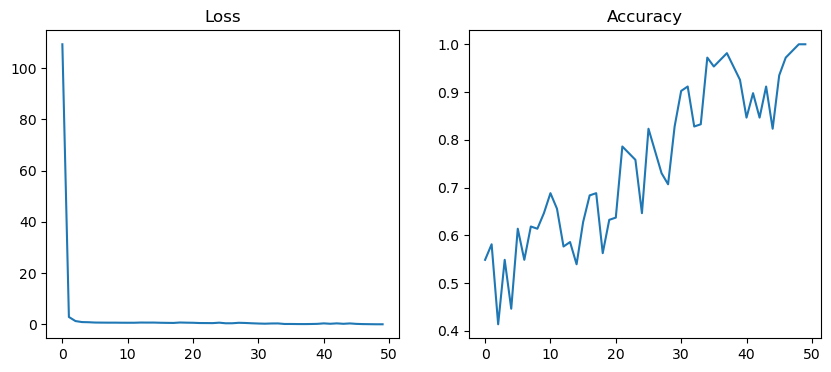

In [20]:
# 打印训练历史记录中的所有键
print(history.history.keys())

# 绘制损失函数和准确率曲线在同一张图上，一左一右
plt.figure(figsize=(10, 4))

# 损失函数曲线在左侧
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Loss')

# 准确率曲线在右侧
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')

# 显示图形
plt.show()


## 輸出預設值

0 False - Bart

1 True  - Homer

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
[[0.0182978 ]
 [0.9982666 ]
 [0.04062988]
 [0.12276519]
 [0.89954394]]
[[False]
 [ True]
 [False]
 [False]
 [ True]]
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        28
           1       0.74      0.65      0.69        26

    accuracy                           0.72        54
   macro avg       0.72      0.72      0.72        54
weighted avg       0.72      0.72      0.72        54

0.7222222222222222


<Axes: >

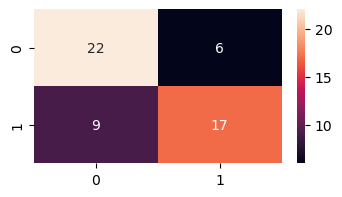

In [28]:

predictions = network1.predict(X_test)
print(predictions[:5]) #輸出前五就好

predictions = (predictions > 0.5)
print(predictions[:5])

# 產生分類報告
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


# 計算精確率並繪製混淆矩陣
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_test, predictions))
cm = confusion_matrix(y_test, predictions)
cm
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True)

## 儲存/載入模型

In [29]:
# 保存模型結構
model_json = network1.to_json()
with open('network1.json', 'w') as json_file:
  json_file.write(model_json)


# 保存模型參數
from keras.models import save_model
network1_saved = save_model(network1, 'weights1.hdf5')
  

In [30]:
# 載入模型結構
with open('network1.json') as json_file:
  json_saved_model = json_file.read()
json_saved_model

# 載入模型參數
network1_loaded = tf.keras.models.model_from_json(json_saved_model)
network1_loaded.load_weights('./weights1.hdf5')
network1_loaded.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

network1_loaded.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8193)           │   134,242,305 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8193)           │    67,133,442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,383,941 (768.22 MB)

 Trainable params: 201,383,941 (768.22 MB)

 Non-trainable params: 0 (0.00 B)

## 針對圖片進行辨識

In [36]:
test_image = X_test[0]
print(test_image)
print(test_image.shape)
test_image = scaler.inverse_transform(test_image.reshape(1, -1))
print(test_image)

[1. 1. 1. ... 1. 1. 1.]
(16384,)
[[1. 1. 1. ... 1. 1. 1.]]


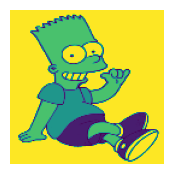

In [40]:
# image_np = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(test_image.reshape(width, height))

In [41]:
print(network1_loaded.predict(test_image)[0])
print(network1_loaded.predict(test_image)[0].shape)

ans = 'Bart' if network1_loaded.predict(test_image)[0] < 0.5 else 'Homer'
print(ans)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
[0.01829724]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(1,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Bart
